# Overfit in Decision Trees and  Random Forest
## CSE Scientific Computing Project 

#### Rebecca Salinas, Undergraduate, University of Texas at Austin
#### Supervisor: Michael Pyrcz, Associate Professor, University of Texas at Austin

Random Forest is a machine learning algorithm that builds on the methods of Decision Trees and Tree 
Bagging. Decision Trees are a nonparametric supervised machine lerning method used for classification and regression. Decision Trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model. Decision Trees are NOT the most powerful or cutting edge method in machine learning but are flexible and easy to interpret. Decision Trees however are vulnerable to overfitting to the training data as they grow more complex, so it is better to keep them simple.

This common issue with Decision Trees can be solved using an Ensemble Tree method, such as Random Forest. Random Forest works to improve the prediction accuracy of a Decision Tree by having a regression model with many decision trees, so that it forms a forest. Random Forest trains each tree with the dataset and randomizes the selection of the feature that is used for each split within each tree. This prevents a single strong predictor from dominating the entire set of trees and thus forces diversity among the trees. Although an individual tree in a Random Forest model may be highly correlated and fit to the data, the nature of the forest allows the model to be resistant to overfitting

This workflow is adapted from the workflow titled "Subsurface Machine Learning with Ensemble Tree Regressor Methods" developed by Michael Pyrcz and focuses on testing the ability of the Random Forest Regressor used in that workflow to resist overfit by changing the complexity and the noise in a model to see if there is a point at which the model overfits and compares it to a Decision Tree model.


#### Importing Required Packages & Libraries

First we begin by importing the necessary packages and libraries. This is done in the following code.

In [6]:
import math                                                 # basic calculations like square root
from sklearn import tree                                    # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                              # for accessing tree information
from sklearn import metrics                                 # measures to check our models
from sklearn.tree import export_graphviz                    # graphical visualization of trees
from sklearn.preprocessing import StandardScaler            # standardize variables to mean of 0.0 and variance of 1.0

from sklearn.model_selection import cross_val_score         # cross validation methods
from sklearn.tree import DecisionTreeRegressor              # decision tree method
from sklearn import model_selection
from sklearn.ensemble import BaggingRegressor               # bagging tree method
from sklearn.ensemble import RandomForestRegressor          # random forest method

import pandas as pd                                         # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
from subprocess import check_call
import geostatspy.GSLIB as GSLIB                            # geostatistics and spatial methods
from scipy.interpolate import spline                        # interpolate
from sklearn.model_selection import train_test_split        # train and test split
import time                                                 # optimize model visualization

#### Declare Functions

Now let's define a few functions that we will be using in this workflow.

In [89]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0,cmap = plt.cm.bwr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response, z_min,z_max,title,):                          # plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return Z

def visualize_grid(Z,xfeature,x_min,x_max,yfeature,y_min,y_max,response, z_min,z_max,title,):                           # plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
def check_model(model,xfeature,yfeature,response,title):           # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))
    
def feature_sample(array, xmin, ymin, xstep, ystep, df_x, df_y, name): # sampling predictions from a feature space grid 
    if array.ndim != 2:
        raise ValueError("Array must be 2D")
    if len(df_x) != len(df_y):
        raise ValueError("x and y feature arrays must have equal lengths")  
    ny, nx = array.shape
    df = pd.DataFrame()
    v = []
    nsamp = len(df_x)
    for isamp in range(nsamp):
        x = df_x.iloc[isamp]
        y = df_y.iloc[isamp]
        iy = min(ny - int((y - ymin) / ystep) - 1, ny - 1)
        ix = min(int((x - xmin) / xstep), nx - 1)
        v.append(array[iy, ix])
    df[name] = v
    return df    
    
def check_grid(grid,xmin,xmax,ymin,ymax,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    if grid.ndim != 2:
        raise ValueError("Prediction array must be 2D")
    ny, nx = grid.shape
    xstep = (xmax - xmin)/nx; ystep = (ymax-ymin)/ny 
    #predict_train = model.predict(np.c_[xfeature,yfeature])
    predict_train = feature_sample(grid, xmin, ymin, xstep, ystep, xfeature, yfeature, 'sample')
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))
    
def training_error(X_train, y_train, model):                            # returns in-sample error for already fit model
    predictions = model.predict(X_train)
    mse = metrics.mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def validation_error(X_test, y_test, model):                             # returns out-of-sample error for already fit model
    predictions = model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse


def sample_size(train_size, max_depth, random_state, n_estimators, max_features):   #returns training and testing errors, as well as variance and correlation
    sample_test = my_data.iloc[train_size:,0:8]                    
    sample_train = my_data.iloc[0:train_size,0:8]                     
    
    sample_subset = sample_train.iloc[:,[0,3,6]]             
    sample_test_subset = sample_test.iloc[:,[0,3,6]] 
    
    predictors = sample_subset[['Por','Brittle']].copy()       
    response = sample_subset[['Production']].copy()           
    predictors_test = sample_test_subset[['Por','Brittle']].copy() 
    response_test = sample_test_subset[['Production']].copy() 

    my_sample_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, \
                                        max_features=max_features)

    my_sample_forest.fit(X = predictors, y = response)           
                        
    predict_train = my_sample_forest.predict(np.c_[sample_test_subset["Por"],sample_test_subset["Brittle"]])
    
    MSE = metrics.mean_squared_error(sample_test_subset["Production"],predict_train)
    Var_Explained = metrics.explained_variance_score(sample_test_subset["Production"],predict_train)
    cor = math.sqrt(metrics.r2_score(sample_test_subset["Production"],predict_train))
    train_error = training_error(predictors, response, my_sample_forest)
    test_error = validation_error(predictors_test, response_test, my_sample_forest)
    
    return train_error, test_error, MSE, Var_Explained, cor

In [182]:
def visualize_tree(tree,xfeature,xmin,xmax,yfeature,ymin,ymax,response,zmin,zmax,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    xstep = (xmax - xmin)/float(100); ystep = (ymax-ymin)/float(100)
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(xmin, xmax, xstep),
                     np.arange(ymin, ymax, ystep))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.inferno,vmin=zmin, vmax=zmax, levels = 100)
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=plt.cm.inferno, norm=None, vmin=zmin, vmax=zmax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="white")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
def check_model_tree(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))
    

def tree_to_code(tree, feature_names):                    # code from StackOverFlow by paulkernfeld
    tree_ = tree.tree_                                    # convert tree object to portable code to use anywhere
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}elif {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1) 
    
def get_lineage(tree, feature_names):                     # code from StackOverFlow by Zelanzny7
    left      = tree.tree_.children_left                  # track the decision path for any set of inputs
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    # get ids of child nodes
    idx = np.argwhere(left == -1)[:,0]     
    def recurse(left, right, child, lineage=None):          
        if lineage is None:
            lineage = [child]
        if child in left:
            parent = np.where(left == child)[0].item()
            split = 'l'
        else:
            parent = np.where(right == child)[0].item()
            split = 'r'
        lineage.append((parent, split, threshold[parent], features[parent]))
        if parent == 0:
            lineage.reverse()
            return lineage
        else:
            return recurse(left, right, parent, lineage)
    for child in idx:
        for node in recurse(left, right, child):
            print(node) 

#### Read in the data set

Next we will be reading in the the data. For now we will use the "unconv_MV.csv" comma delimited file from https://github.com/GeostatsGuy/GeoDataSets

> unconv_MV.csv is an artificial dataset that contains porosity, log permeability, acoustic impedence (AI), brittleness, total organic content (TOC), VR, and production data for 1000 wells.

In [9]:
my_data_original = pd.read_csv("unconv_MV.csv")                      # load the comma delimited data file using pandas

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [10]:
my_data_original[:5]                                                 # preview the first 5 rows of the dataframe

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919


### Summary Statistics

Let's remove the well index and check the summary statistics. 

Checking the summary statistics allows us to gain a deeper understanding of the data and see any erroneous data points. 


In [11]:
my_data = my_data_original.iloc[:,1:8]                  # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                          # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


As we can see from the summary statistics table above, we have some negative values for brittleness and total organic carbon. This is physically imposible so the values must be erroneous. We know the lowest possible values are 0.0, so we will truncate on 0.0. 

We use the get_numerical_data() DataFrame member function to get a shallow copy of the data from the DataFrame. Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame. This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

#### Truncate Negative Values

In [12]:
num = my_data._get_numeric_data()                           
num[num < 0] = 0   

In [13]:
my_data.describe().transpose()    

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


Now the negative values have been replaced by 0

#### Split Data Into Test and Train Subsets

We need to split our data set into testing and training subsets. We will extract 700 samples for testing and keep 300 samples for training. The smaller the training sample size, the more challenging it is to model.

In [14]:
my_data_test = my_data.iloc[300:,0:8]                    # extract 700 samples for testing 

my_data_train = my_data.iloc[0:300,0:8]                  # keep 300 samples for training                   

Recalculate the summary statistics for our subsets

In [15]:
my_data_train.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
Por,300.0,14.665567,3.067537,5.400000,12.567500,14.600000,16.705000,23.850000
LogPerm,300.0,1.383500,0.413808,0.240000,1.140000,1.365000,1.660000,2.570000
AI,300.0,3.008800,0.583795,1.210000,2.610000,3.000000,3.392500,4.700000
Brittle,300.0,50.577900,15.063097,0.000000,39.972500,49.635000,59.472500,93.470000
TOC,300.0,0.968100,0.512586,0.000000,0.630000,0.940000,1.295000,2.710000
VR,300.0,1.982000,0.318500,0.900000,1.807500,2.010000,2.170000,2.840000
Production,300.0,2163.794498,1385.996631,2.713535,1198.823083,1918.290331,2917.155099,8554.267033


In [16]:
my_data_test.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
Por,700.0,15.072557,3.007191,5.790000,12.940000,15.195000,17.177500,24.65000
LogPerm,700.0,1.405471,0.402677,0.120000,1.130000,1.400000,1.690000,2.58000
AI,700.0,2.971386,0.575020,0.960000,2.557500,3.010000,3.340000,4.63000
Brittle,700.0,49.368729,15.017095,0.000000,39.652500,49.720000,58.905000,89.85000
TOC,700.0,1.022486,0.493746,0.000000,0.650000,1.030000,1.370000,2.56000
VR,700.0,1.995100,0.303818,0.930000,1.810000,1.980000,2.180000,2.90000
Production,700.0,2283.082085,1496.079421,9.854247,1180.670891,2009.467003,3077.488749,12568.64413


#### Set Feature Ranges
Using the summary statistics, let's set the feature ranges for the predictor and response features we are interested in. In this case porosity, brittleness, and production.

In [17]:
pormin = 5.0; pormax = 25.0                                 # set minumums and maximums for visualization using full data
brittlemin = 0.0; brittlemax = 100.0
prodmin = 0.0; prodmax = 13000.0

#### Working with Only Two Features

Let's simplify the problem to 2 features, Porosity and Brittleness to predict Production. By working with only 2 features, it is very easy to visualize the segmentation of the feature space (it is only 2D and can be shown completely on a single plot).


* we split into train, test

Let's also make a DataFrame with train and test together.

* after we tune the hyperparameter we will train the model with the best level of complexity with all the data

In [18]:
my_data_subset = my_data_train.iloc[:,[0,3,6]]             # extract just por, brittle and prod with 300 training samples
my_data_test_subset = my_data_test.iloc[:,[0,3,6]] 

#### Separate Predictor & Response Features

In [19]:
predictors = my_data_subset[['Por','Brittle']].copy()       # make a new DataFrame with predictor features for training
response = my_data_subset[['Production']].copy()            # make a new DataFrame with responses features for training
predictors_test = my_data_test_subset[['Por','Brittle']].copy() # make a new DataFrame with predictor features for testing
response_test = my_data_test_subset[['Production']].copy()  # make a new DataFrame with responses for testing

### Random Forest Regression

###### 1. Set the hyperparameters.


* Even if I am just running one model, I set the random number seed to ensure I have a deterministic model, a model that can be rerun to get the same result everytime. If the random number seed is not set, then it is likely set based on the system time.

```python
seed = 73093
```

* We will overtrain the trees, let them grow overly complicated. Once again, the ensemble approach will mitigate model variance and overfit.

```python
max_depth = 7
```

* We will use a large number of trees to mitigate model variance and to benefit from random forest tree diversity.

```python
num_tree = 500
```
* We are using a simple 2 predictor feature example for ease of visualization.  The default for scikit learn's random forest is to select $\frac{m}{3}$  features at random for consideration for each split.  

* This doesn't make much sense when $m = 2$, as with our case, so we set the maximum number of features considered for each split to 1.  

* We are forcing random selection of porosity or brittleness for consideration with each split, hierarchical binary segmentation.

```python
max_features = 1
```


###### 2. Instantiate the random forest regressor with our hyperparameters  

```python
my_first_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features)
```


###### 3. Train the random forest regression

```python
my_first_forest.fit(X = predictors, y = response)
```


###### 4. Visualize the model result over the feature space (easy to do as we have only 2 predictor features)

Let's build, visualize and cross validate our first random forest regression model.


We will begin by creating our random forest model.

Mean Squared Error on Training =  185016.51 , Variance Explained = 0.92 Cor = 0.96


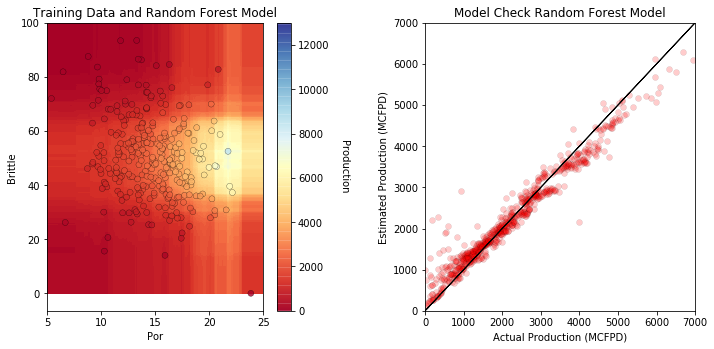

In [20]:
import warnings
warnings.filterwarnings('ignore') 

# set the random forest hyperparameters
seed = 73093     
max_depth = 7
num_tree = 500
max_features = 1

# instantiate the random forest regressor
my_first_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, \
                                        max_features=max_features)

# train the model with training data
my_first_forest.fit(X = predictors, y = response)           

# predict with the model over the predictor feature space and visualize
plt.subplot(121)                        
visualize_model(my_first_forest,my_data_subset["Por"],pormin,pormax,my_data_subset["Brittle"],\
                brittlemin,brittlemax,my_data_subset["Production"],prodmin,prodmax,'Training Data and Random Forest Model')

# perform cross validation with withheld testing data
plt.subplot(122)                        
check_model(my_first_forest,my_data_test_subset["Por"],my_data_test_subset["Brittle"],\
            my_data_test_subset["Production"],'Model Check Random Forest Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.4, hspace=0.2)

Here we see a random forest model without any added noise or complexity. Just modeled using our dataset. Before we set this as our benchmark case, let's look at Out-of-Bag and feature importance.


#### Model Performance by Out-of-Bag and Feature Importance
Since we are building a robust model with a large ensemble of trees, let's get more serious about model checking.

* we will look at out-of-bag mean square error

* we will look at feature importance

We'll start with feature importance.

In [21]:
my_first_forest.feature_importances_

array([0.59873557, 0.40126443])

We can plot this with a bar chart and include the error bar using the feature importance from every tree in the fores

1. feature 0 (0.598736)
2. feature 1 (0.401264)


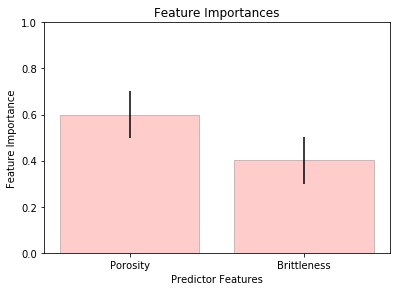

In [22]:
importances = my_first_forest.feature_importances_               # expected (global) importance over the forest fore each predictor feature
std = np.std([tree.feature_importances_ for tree in my_first_forest.estimators_],axis=0) # retrieve importance by tree
indices = np.argsort(importances)[::-1]

features = ['Porosity','Brittleness']                       # names or predictor features

for f in range(len(features)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)
plt.title("Feature Importances")
plt.bar(features, importances[indices],color="red", alpha = 0.2, edgecolor = 'black', yerr=std[indices], align="center")
#plt.xticks(range(X.shape[1]), indices)
plt.ylim(0,1), plt.xlabel('Predictor Features'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

Let's try some hyperparameter training with the out-of-bag mean square error measure from our forest.

Let's start with the number of trees in our forest.

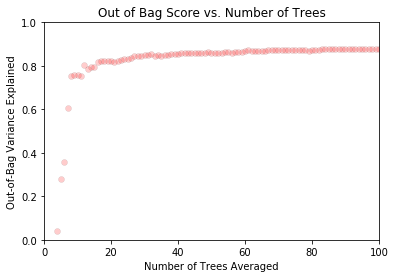

In [23]:
import warnings
warnings.filterwarnings('ignore')
                                  
max_depth = 5                                              # set the random forest hyperparameters
num_trees = np.linspace(1,100,100)
max_features = 1
fit_forests = []
oob_MSE = []

index = 1
for num_tree in num_trees:                                 # loop over number of trees in our random forest
    fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=max_depth, random_state=seed,n_estimators=int(num_tree), max_features=max_features))
    fit_forests[index-1].fit(X = predictors, y = response)
    oob_MSE.append(fit_forests[index-1].oob_score_)
    index = index + 1
    
plt.plot(121)
plt.scatter(num_trees,oob_MSE,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Out of Bag Score vs. Number of Trees'); plt.xlabel('Number of Trees Averaged'); plt.ylabel('Out-of-Bag Variance Explained')
plt.xlim(0,100); plt.ylim(0,1.0)

plt.show()

Now let's try the depth of the trees, given enough trees (we'll use 60 trees) as determined above.

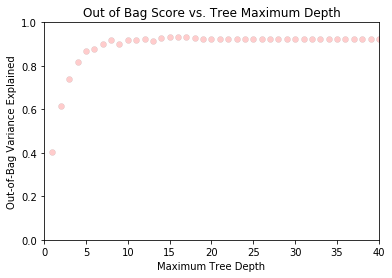

In [24]:
import warnings
warnings.filterwarnings('ignore')
                                  
max_depths = np.linspace(1,40,40)                          # set the tree maximum tree depths to consider

num_tree = 60                                              # set the random forest hyperparameters
max_features = 1
fit_forests = []
oob_MSE = []

index = 1
for max_depth in max_depths:                               # loop over tree depths
    fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=int(max_depth), random_state=seed,n_estimators=num_tree, max_features=max_features))
    fit_forests[index-1].fit(X = predictors, y = response)
    oob_MSE.append(fit_forests[index-1].oob_score_)
    index = index + 1
    
plt.plot(121)                                           # plot the variance explained vs. tree depth
plt.scatter(max_depths,oob_MSE,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Out of Bag Score vs. Tree Maximum Depth'); plt.xlabel('Maximum Tree Depth'); plt.ylabel('Out-of-Bag Variance Explained')
plt.xlim(0,40); plt.ylim(0,1.0)

plt.show()

It looks like we need a maximum tree depth of at least 10 splits for best performance of our model with respect to out-of-bag samples variance explained.

Let's recreate our forest with a tuned model!
#### Tuned Model (Benchmark)
In theory, the optimal random forest model for this dataset has at least 60 trees with a maximun tree depth of 10.

Let's model this.

Mean Squared Error on Training =  153793.76 , Variance Explained = 0.93 Cor = 0.96


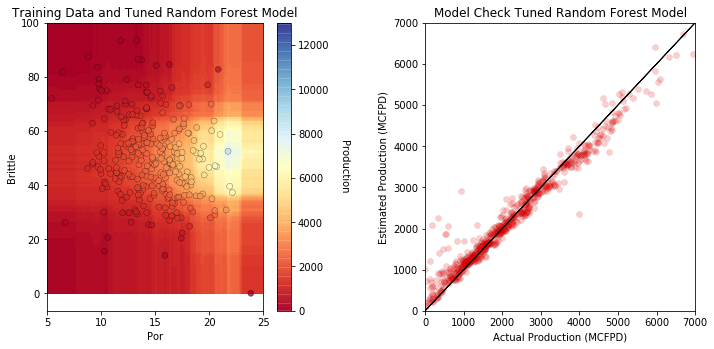

In [25]:
# set the random forest hyperparameters
seed = 73093     
max_depth = 10
num_tree = 60
max_features = 1

# instantiate the random forest regressor
tuned_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, \
                                        max_features=max_features)

# train the model with training data
tuned_forest.fit(X = predictors, y = response)           

# predict with the model over the predictor feature space and visualize
plt.subplot(121)                        
visualize_model(tuned_forest,my_data_subset["Por"],pormin,pormax,my_data_subset["Brittle"],\
                brittlemin,brittlemax,my_data_subset["Production"],prodmin,prodmax,'Training Data and Tuned Random Forest Model')

# perform cross validation with withheld testing data
plt.subplot(122)                        
check_model(tuned_forest,my_data_test_subset["Por"],my_data_test_subset["Brittle"],\
            my_data_test_subset["Production"],'Model Check Tuned Random Forest Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.4, hspace=0.2)

This will be our benchmark case to compare, that is our forest that has no added noise or complexity. It is tuned to optimal performance.

We can see that in the benchmark case the MSE (validation error) is 153793.76, the Variance Explained is .93, and the Correlation is .96


Here are the summarized statistics for this case:
* seed = 73093 
* max_depth = 10
* num_tree = 60 
* max_features = 1 
* MSE = 153793.76 
* Variance Explained = 0.93 
* Correlation = 0.96 

Now our goal is to test our model to see if it will overfit.

### What is Overfit?
Now that we have played around with different features of a random forest and have a tuned baseline model, let's review what exactly overfit means.

Overfitting means the model is learning from the noise in the dataset and it's ability to generalize the results is low.

This means we would have a
* small training error
* large validation (testing) error

One way to inspect if there is overfit is to plot the evolution of training and validation errors. The training error should always decrease but the validation error goes up at some point. That is the point at which we need to stop training to avoid overfitting.

Below is a standard graph of testing and training error vs model complexity. The area boxed in and labeled as High Variance is where the model would be considered overfit (aka the training error is decreasing but the validation error is increasing). The boxed area labeled High Bias is where the model would be underfitting, and the space in the middle is the area where our model would fit just right. 

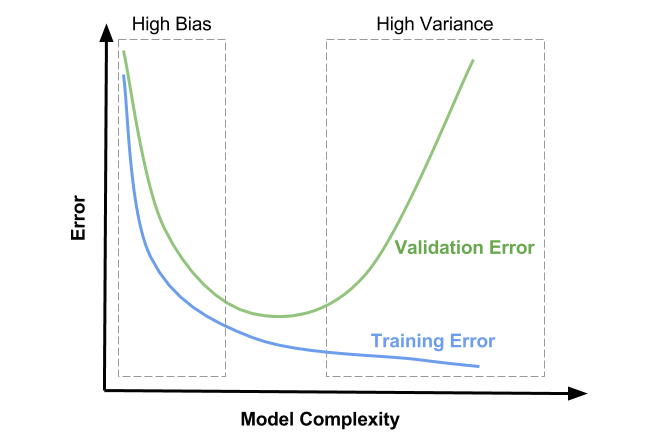

Our goal is to test the robustness of our random forest model and it's ability to resist overfitting. We will be using the concepts of the figure above to compare.


Let's start with a simple experiment in which we will only change the size of the training and testing samples to see how that affects our training and validation error. In theory, the greater the training data and smaller the testing the more overfit we will have.

#### Sample Size

Let's use our function sample size to change our testing and training samples and record the training and validation errors.

In [26]:
#We will use the same hyperparameters as our benchmark case
seed = 73093     
max_depth = 10
num_tree = 60
max_features = 1

training_size = 100
training_error_array = []
testing_error_array = []
training_size_array = []

num_tree_array = []
mse_array = []
var_explained_array = []
cor_array = [] 

while training_size < 1000:
    train, test, mean, var, corr = sample_size(training_size, max_depth=max_depth, random_state=seed, n_estimators=num_tree, max_features=max_features)
    
    training_size_array.append(training_size)
    training_error_array.append(train)
    testing_error_array.append(test)
    mse_array.append(mean)
    var_explained_array.append(var)
    cor_array.append(corr)
    
    training_size += 100

Text(0,0.5,'Error')

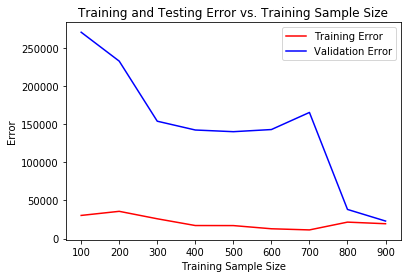

In [27]:
plt.plot(training_size_array, training_error_array, c='red', label = 'Training Error')
plt.plot(training_size_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Training Sample Size') 
plt.xlabel('Training Sample Size')
plt.ylabel('Error')

As we can see from this graph, increasing the training sample size (or reducing our testing sample) also increases our training error and eventually reduces our validation error. 

When the testing error is much higher than the training error we have overfit. In this case, that seems to begin to occur at around 500 samples as the validation error starts to increase, however our model forces the error back down at around 700 samples, preventing the overfitting we see in our example graph.

Recall that to avoid overfitting we should traditionally stop the model at the point at which the testing error starts increasing (about 500 samples), however this random forest model is resistant to overfit (at least when it comes to training and testing sample sizes). The only part at which the model seems to overfit is between using 600 and 700 training samples, as we can see the training error decreases and the validation error increases.

It is important to note that the training error is always very low compared to the validation error.

Let's see how MSE, Variance Explained, and Correlation compare as we vary training sample size.

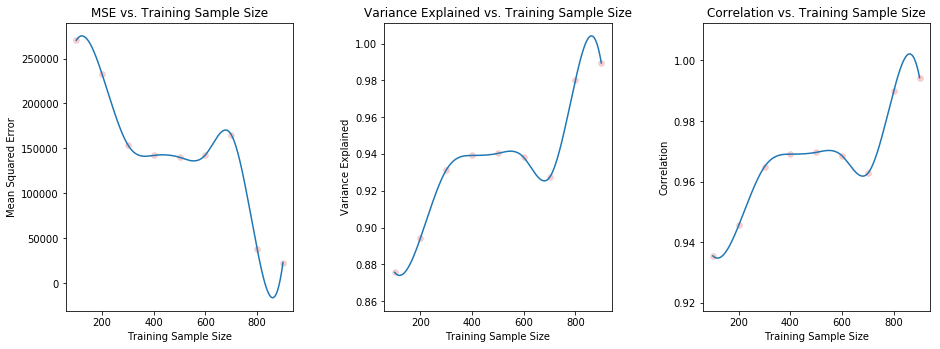

In [28]:
plt.subplot(131)
plt.scatter(training_size_array,mse_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('MSE vs. Training Sample Size') 
plt.xlabel('Training Sample Size')
plt.ylabel('Mean Squared Error')
training_size_array_new = np.linspace(min(training_size_array), max(training_size_array), 300)  
mse_smooth = spline(training_size_array, mse_array, training_size_array_new)
plt.plot(training_size_array_new,mse_smooth)


plt.subplot(132)
plt.scatter(training_size_array,var_explained_array, s=None, c='red', marker=None, cmap=None, norm=None, \
            vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black") 
plt.title('Variance Explained vs. Training Sample Size') 
plt.xlabel('Training Sample Size')
plt.ylabel('Variance Explained') 
var_smooth = spline(training_size_array, var_explained_array, training_size_array_new)
plt.plot(training_size_array_new,var_smooth)


plt.subplot(133)
plt.scatter(training_size_array,cor_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Correlation vs. Training Sample Size') 
plt.xlabel('Training Sample Size')
plt.ylabel('Correlation')
cor_smooth = spline(training_size_array, cor_array, training_size_array_new)
plt.plot(training_size_array_new,cor_smooth)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

#### Forest Size (Number of Trees)
Let's observe the training and validation errors, MSE, Var, and the Cor if we simply increase the number of trees.

In [29]:
seed = 73093
max_depth = 7
num_tree = 1   
max_features = 1

num_tree_array = []
mse_array = []
var_explained_array = []
cor_array = [] 

testing_error_array = []
training_error_array = []

while num_tree < 600: 
    my_model = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, \
                                      max_features=max_features)

    my_model.fit(X = predictors, y = response) 
    
    
    predict_train = my_model.predict(np.c_[my_data_test_subset["Por"],my_data_test_subset["Brittle"]])
    MSE = metrics.mean_squared_error(my_data_test_subset["Production"],predict_train)
    Var_Explained = metrics.explained_variance_score(my_data_test_subset["Production"],predict_train)
    cor = math.sqrt(metrics.r2_score(my_data_test_subset["Production"],predict_train))
    
    train = training_error(predictors, response, my_model)
    test = validation_error(predictors_test, response_test, my_model)
    
    num_tree_array.append(num_tree)
    mse_array.append(MSE)
    var_explained_array.append(Var_Explained)
    cor_array.append(cor)
    
    training_error_array.append(train)
    testing_error_array.append(test)
    
    num_tree += 10

Text(0,0.5,'Error')

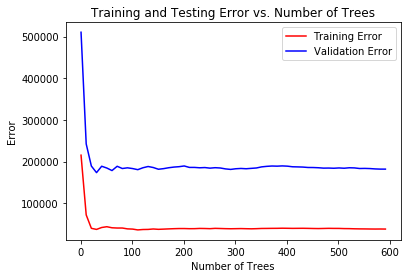

In [30]:
plt.plot(num_tree_array, training_error_array, c='red', label = 'Training Error')
plt.plot(num_tree_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Number of Trees') 
plt.xlabel('Number of Trees')
plt.ylabel('Error')

As we can see from this graph, increasing the number of treesdecreses both training and validation error at about the same rate and then they both flatline. This may indicate that the model is underfitting. This means that after increasing the number of trees to a certain point, adding additional trees will not have a significant effect on the model.

Let's observe the MSE, Var, and the Cor.

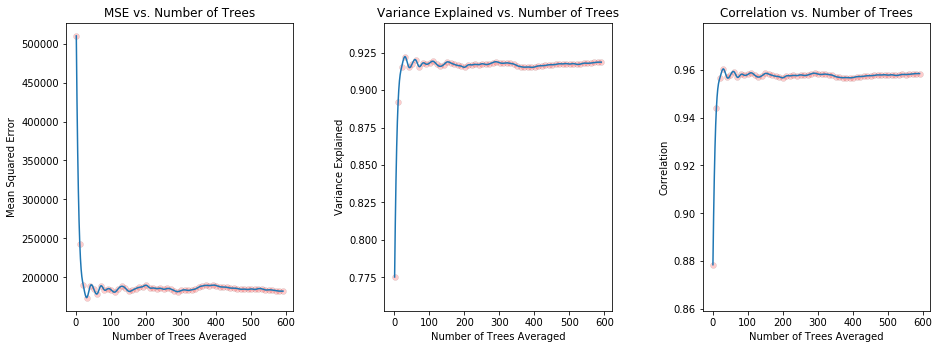

In [31]:
plt.subplot(131)
plt.scatter(num_tree_array,mse_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('MSE vs. Number of Trees') 
plt.xlabel('Number of Trees Averaged')
plt.ylabel('Mean Squared Error')
num_tree_new = np.linspace(min(num_tree_array), max(num_tree_array), 300)  
mse_smooth = spline(num_tree_array, mse_array, num_tree_new)
plt.plot(num_tree_new,mse_smooth)


plt.subplot(132)
plt.scatter(num_tree_array,var_explained_array, s=None, c='red', marker=None, cmap=None, norm=None, \
            vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black") 
plt.title('Variance Explained vs. Number of Trees') 
plt.xlabel('Number of Trees Averaged')
plt.ylabel('Variance Explained') 
var_smooth = spline(num_tree_array, var_explained_array, num_tree_new)
plt.plot(num_tree_new,var_smooth)


plt.subplot(133)
plt.scatter(num_tree_array,cor_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Correlation vs. Number of Trees') 
plt.xlabel('Number of Trees Averaged')
plt.ylabel('Correlation')
cor_smooth = spline(num_tree_array, cor_array, num_tree_new)
plt.plot(num_tree_new,cor_smooth)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

Again we see a similar flatline effect. In general the lower the number of trees, the closer the model is to a decision tree, with a restricted feature set, thus the closer to overfitting.

#### Tree Complexity (Tree Depth)
Now let's see how the training and validation errors, MSE, Var, and the Cor behave if we simply increase the tree complexity (aka tree depth).

In [32]:
seed = 73093
max_depth = 1
num_tree = 60   
max_features = 1

max_depth_array = []
mse_array = []
var_explained_array = []
cor_array = [] 

testing_error_array = []
training_error_array = []

while max_depth < 50: 
    my_model = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, \
                                      max_features=max_features)

    my_model.fit(X = predictors, y = response) 
    
    predict_train = my_model.predict(np.c_[my_data_test_subset["Por"],my_data_test_subset["Brittle"]])
    MSE = metrics.mean_squared_error(my_data_test_subset["Production"],predict_train)
    Var_Explained = metrics.explained_variance_score(my_data_test_subset["Production"],predict_train)
    cor = math.sqrt(metrics.r2_score(my_data_test_subset["Production"],predict_train))
    
    train = training_error(predictors, response, my_model)
    test = validation_error(predictors_test, response_test, my_model)
    
    max_depth_array.append(max_depth)
    mse_array.append(MSE)
    var_explained_array.append(Var_Explained)
    cor_array.append(cor)
    
    training_error_array.append(train)
    testing_error_array.append(test)
    
    max_depth += 1

Text(0,0.5,'Error')

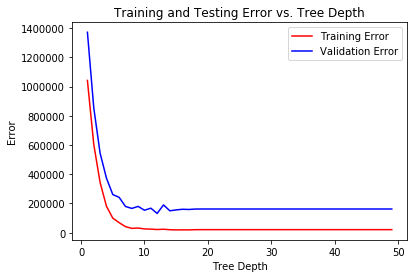

In [33]:
plt.plot(max_depth_array, training_error_array, c='red', label = 'Training Error')
plt.plot(max_depth_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Tree Depth') 
plt.xlabel('Tree Depth')
plt.ylabel('Error')

As we can see from this graph, increasing the tree depth decreases our training and validation errors until they eventually flatline. Again as we saw before, the flatline could be an indication of underfitting, but it is most likely showing how the model is not going to overfit with increasing tree complexity.

This makes sense! With random forest it does not matter if each tree is overfit because as long as there is diversity between the tree the model will be resistant to overfitting.

Interestingly there seems to be a little bit of overfitting occurring at around tree depth = 12 as the validation error starts to increase and the training error continues to decrease, but it does not last.

Let's observe the MSE, Var, and the Cor.

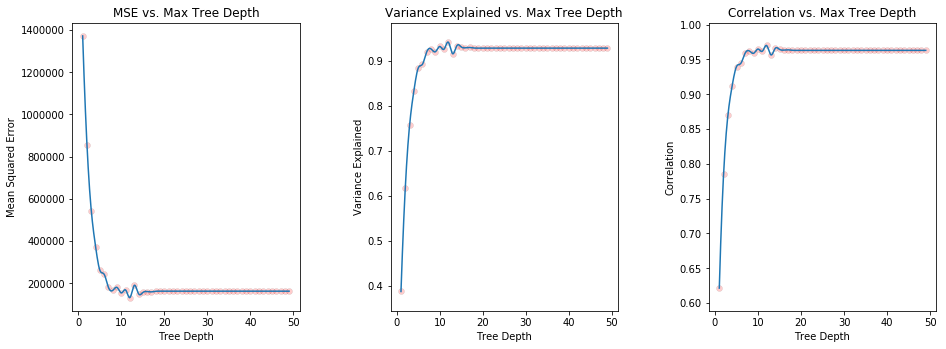

In [34]:
plt.subplot(131)
plt.scatter(max_depth_array,mse_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('MSE vs. Max Tree Depth') 
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
max_depth_new = np.linspace(min(max_depth_array), max(max_depth_array), 300)  
mse_smooth = spline(max_depth_array, mse_array, max_depth_new)
plt.plot(max_depth_new,mse_smooth)


plt.subplot(132)
plt.scatter(max_depth_array,var_explained_array, s=None, c='red', marker=None, cmap=None, norm=None, \
            vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black") 
plt.title('Variance Explained vs. Max Tree Depth') 
plt.xlabel('Tree Depth')
plt.ylabel('Variance Explained') 
var_smooth = spline(max_depth_array, var_explained_array, max_depth_new)
plt.plot(max_depth_new,var_smooth)


plt.subplot(133)
plt.scatter(max_depth_array,cor_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Correlation vs. Max Tree Depth') 
plt.xlabel('Tree Depth')
plt.ylabel('Correlation')
cor_smooth = spline(max_depth_array, cor_array, max_depth_new)
plt.plot(max_depth_new,cor_smooth)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

Again we see a similar flatline effect with Variance and Correlation.

#### Adding Noise to the Data
Now let's see how the training and testing errors, MSE, Variance Explained, and Correlation respond to added noise in the dataset. We will start by adding noise to the response feature (Production)

In [35]:
std_error = 0

seed = 73093
max_depth = 10
num_tree = 60   
max_features = 1

std_error_array = []
mse_array = []
var_explained_array = []
cor_array = [] 

testing_error_array = []
training_error_array = []


while std_error <= 1000:
    
    my_data_noise = my_data_original.copy()
    
    my_data_noise = my_data_noise.iloc[:,1:8] 
    
    subset_noise = my_data_noise.iloc[:,[0,3,6]]          # extract just por, brittle and prod with 300 training samples
    
    subset_noise['Production'] = subset_noise['Production'] + np.random.normal(loc = 0.0,scale=std_error,size=len(my_data))
    
    num = subset_noise._get_numeric_data()                           # truncate negative values
    num[num < 0] = 0 
    
    test_noise = subset_noise.iloc[300:,:]                         # split data                
    train_noise = subset_noise.iloc[0:300,:]
    
    predictors = train_noise[['Por','Brittle']].copy()       # make a new DataFrame with predictor features for training
    response = train_noise[['Production']].copy()            # make a new DataFrame with responses features for training
    
    predictors_test = test_noise[['Por','Brittle']].copy()    # make a new DataFrame with predictor features for testing
    response_test = test_noise[['Production']].copy()         # make a new DataFrame with responses for testing
    
    my_model = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, \
                                      max_features=max_features)

    my_model.fit(X = predictors, y = response) 
    
    predict_train = my_model.predict(np.c_[test_noise["Por"],test_noise["Brittle"]])
    MSE = metrics.mean_squared_error(test_noise["Production"],predict_train)
    Var_Explained = metrics.explained_variance_score(test_noise["Production"],predict_train)
    cor = math.sqrt(metrics.r2_score(test_noise["Production"],predict_train))
    
    train = training_error(predictors, response, my_model)
    test = validation_error(predictors_test, response_test, my_model)
    
    std_error_array.append(std_error)
    mse_array.append(MSE)
    var_explained_array.append(Var_Explained)
    cor_array.append(cor)
    
    training_error_array.append(train)
    testing_error_array.append(test)
    
    std_error += 50

Text(0,0.5,'Error')

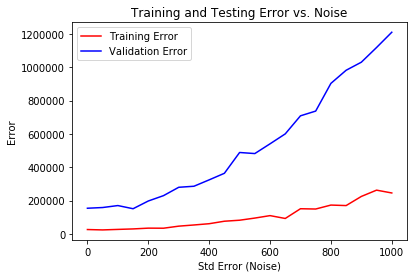

In [36]:
plt.plot(std_error_array, training_error_array, c='red', label = 'Training Error')
plt.plot(std_error_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Noise') 
plt.xlabel('Std Error (Noise)')
plt.ylabel('Error')

Finally something that doesn't flatline! 

We can see here that as we add noise to our production data both the validation and training error increase. This however does not lead to overfit, it actually leads to the opposite. In this case reducing noise would cause overfitting.

Let's observe the MSE, Var, and the Cor.

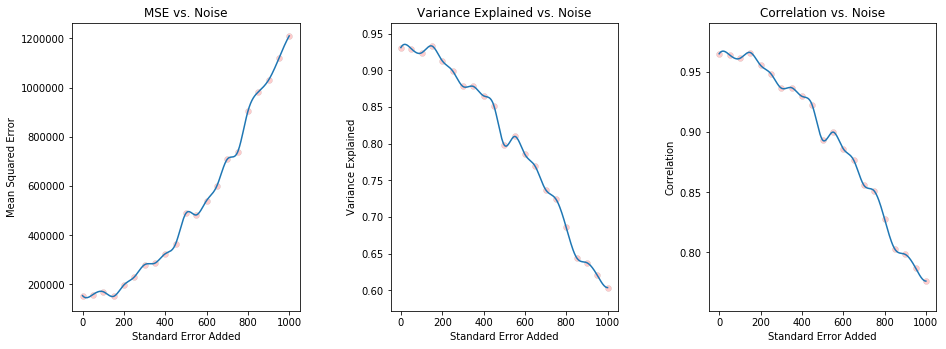

In [37]:
plt.subplot(131)
plt.scatter(std_error_array,mse_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('MSE vs. Noise') 
plt.xlabel('Standard Error Added')
plt.ylabel('Mean Squared Error')
std_error_new = np.linspace(min(std_error_array), max(std_error_array), 300)  
mse_smooth = spline(std_error_array, mse_array, std_error_new)
plt.plot(std_error_new,mse_smooth)


plt.subplot(132)
plt.scatter(std_error_array,var_explained_array, s=None, c='red', marker=None, cmap=None, norm=None, \
            vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black") 
plt.title('Variance Explained vs. Noise') 
plt.xlabel('Standard Error Added')
plt.ylabel('Variance Explained') 
var_smooth = spline(std_error_array, var_explained_array, std_error_new)
plt.plot(std_error_new,var_smooth)


plt.subplot(133)
plt.scatter(std_error_array,cor_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Correlation vs. Noise') 
plt.xlabel('Standard Error Added')
plt.ylabel('Correlation')
cor_smooth = spline(std_error_array, cor_array, std_error_new)
plt.plot(std_error_new,cor_smooth)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

When adding noise to the response feature, we can see that as we increase the standard error the MSE increases, and the variance explained and correlation decrease.

### Increasing the Model Complexity

We have now individually changed the number of trees, tree depth, training sample size, and noise individually and have not seen any evidence of overfitting occurring in our model, so now we will create a nested loop to combine and change multiple things at once.

In [38]:
std_error = 0

seed = 73093
max_depth = 10
num_tree = 60   
max_features = 1

std_error_array = []
mse_array = []
var_explained_array = []
cor_array = [] 
max_depth_array = []

testing_error_array = []
training_error_array = []

#loop to add noise
while std_error <= 1500:
    
    #nested loop to add tree complexity
    while max_depth < 60: 
        my_data_noise = my_data_original.copy()
    
        my_data_noise = my_data_noise.iloc[:,1:8] 
    
        subset_noise = my_data_noise.iloc[:,[0,3,6]]          # extract just por, brittle and prod with 300 training samples
    
        subset_noise['Production'] = subset_noise['Production'] + np.random.normal(loc = 0.0,scale=std_error,size=len(my_data))
    
        num = subset_noise._get_numeric_data()                           # truncate negative values
        num[num < 0] = 0 
    
        test_noise = subset_noise.iloc[300:,:]                         # split data                
        train_noise = subset_noise.iloc[0:300,:]
    
        predictors = train_noise[['Por','Brittle']].copy()       # make a new DataFrame with predictor features for training
        response = train_noise[['Production']].copy()            # make a new DataFrame with responses features for training
    
        predictors_test = test_noise[['Por','Brittle']].copy()    # make a new DataFrame with predictor features for testing
        response_test = test_noise[['Production']].copy()         # make a new DataFrame with responses for testing
    
    
    
        my_model = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, \
                                      max_features=max_features)

        my_model.fit(X = predictors, y = response) 
    
        predict_train = my_model.predict(np.c_[test_noise["Por"],test_noise["Brittle"]])
        MSE = metrics.mean_squared_error(test_noise["Production"],predict_train)
        Var_Explained = metrics.explained_variance_score(test_noise["Production"],predict_train)
        cor = math.sqrt(metrics.r2_score(test_noise["Production"],predict_train))
    
        train = training_error(predictors, response, my_model)
        test = validation_error(predictors_test, response_test, my_model)
    
        max_depth_array.append(max_depth)
        mse_array.append(MSE)
        var_explained_array.append(Var_Explained)
        cor_array.append(cor)
    
        training_error_array.append(train)
        testing_error_array.append(test)
        
        max_depth += 1
        
        std_error_array.append(std_error)
        std_error += 50

Text(0,0.5,'Error')

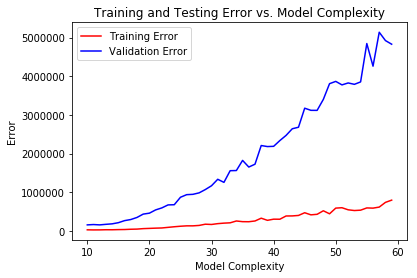

In [39]:
plt.plot(max_depth_array, training_error_array, c='red', label = 'Training Error')
plt.plot(max_depth_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Model Complexity') 
plt.xlabel('Model Complexity')
plt.ylabel('Error')

Interestingly our errors look very similar to those when just adding noise. Both the training and validation errors increase as model complexity increases which means that we do not have overfit occurring.

Let's investigate as we keep increasing complexity.

In [44]:
std_error = 0

seed = 73093
max_depth = 10
num_tree = 60   
max_features = 1

std_error_array = []
mse_array = []
var_explained_array = []
cor_array = [] 
max_depth_array = []

testing_error_array = []
training_error_array = []

#loop to add noise
while std_error <= 2500:
    
    #nested loop to add tree complexity
    while max_depth < 70: 
        my_data_noise = my_data_original.copy()
    
        my_data_noise = my_data_noise.iloc[:,1:8] 
    
        subset_noise = my_data_noise.iloc[:,[0,3,6]]          # extract just por, brittle and prod with 300 training samples
    
        subset_noise['Production'] = subset_noise['Production'] + np.random.normal(loc = 0.0,scale=std_error,size=len(my_data))
    
        num = subset_noise._get_numeric_data()                           # truncate negative values
        num[num < 0] = 0 
    
        test_noise = subset_noise.iloc[300:,:]                         # split data                
        train_noise = subset_noise.iloc[0:300,:]
    
        predictors = train_noise[['Por','Brittle']].copy()       # make a new DataFrame with predictor features for training
        response = train_noise[['Production']].copy()            # make a new DataFrame with responses features for training
    
        predictors_test = test_noise[['Por','Brittle']].copy()    # make a new DataFrame with predictor features for testing
        response_test = test_noise[['Production']].copy()         # make a new DataFrame with responses for testing
    
    
    
        my_model = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, \
                                      max_features=max_features)

        my_model.fit(X = predictors, y = response) 
    
        predict_train = my_model.predict(np.c_[test_noise["Por"],test_noise["Brittle"]])
        MSE = metrics.mean_squared_error(test_noise["Production"],predict_train)
        Var_Explained = metrics.explained_variance_score(test_noise["Production"],predict_train)
        cor = math.sqrt(metrics.r2_score(test_noise["Production"],predict_train))
    
        train = training_error(predictors, response, my_model)
        test = validation_error(predictors_test, response_test, my_model)
    
        max_depth_array.append(max_depth)
        mse_array.append(MSE)
        var_explained_array.append(Var_Explained)
        cor_array.append(cor)
    
        training_error_array.append(train)
        testing_error_array.append(test)
        
        max_depth += 1
        
        std_error_array.append(std_error)
        std_error += 50

Text(0,0.5,'Error')

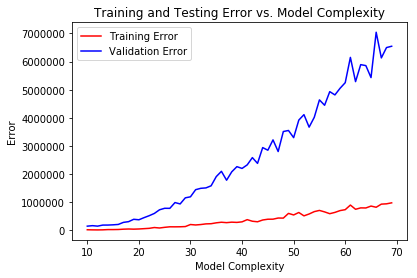

In [45]:
plt.plot(max_depth_array, training_error_array, c='red', label = 'Training Error')
plt.plot(max_depth_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Model Complexity') 
plt.xlabel('Model Complexity')
plt.ylabel('Error')

Our validation error continues to trend upwards however it becomes very unstable.

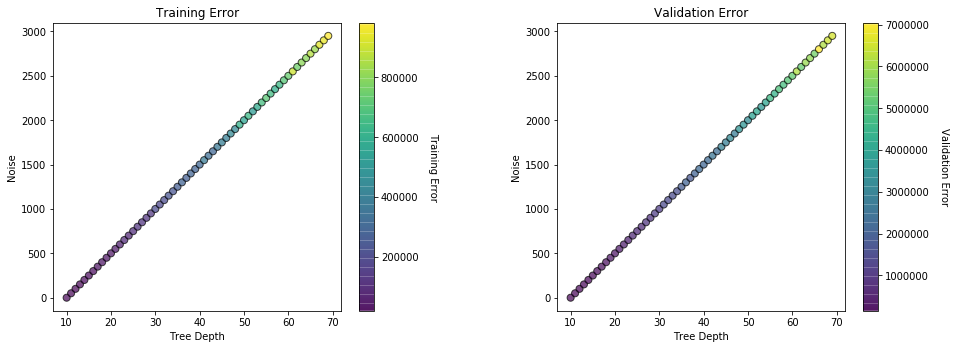

In [145]:
plt.subplot(121)
plt.scatter(max_depth_array, std_error_array,linewidths=1, alpha=.7,edgecolor='k',s =50,c= training_error_array)
plt.xlabel('Tree Depth')
plt.ylabel('Noise')
cbar = plt.colorbar(orientation = 'vertical')
cbar.set_label('Training Error', rotation=270, labelpad=20)
plt.title('Training Error')


#fig2 = plt.figure(figsize=(6, 6))
plt.subplot(122)
plt.scatter(max_depth_array, std_error_array,linewidths=1, alpha=.7,edgecolor='k',s =50,c= testing_error_array)
plt.xlabel('Tree Depth')
plt.ylabel('Noise')
cbar = plt.colorbar(orientation = 'vertical')
cbar.set_label('Validation Error', rotation=270, labelpad=20)
plt.title('Validation Error')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

plt.show()

In [130]:
my_data = pd.read_csv("unconv_MV.csv")                    # load the comma delimited data file

In [131]:
my_data[:5]                                             # preview the first 5 rows of the dataframe

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919


In [132]:
my_data = my_data.iloc[:,1:8]                             # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


In [133]:
num = my_data._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


#### Feature Ranges

Let's set some ranges for plotting. Note for the standardized predictor features we will use -3.5 to 3.5 as the limits.

In [134]:
pormin = 5.0; pormax = 25.0                                 # set minumums and maximums for visualization 
brittlemin = 0.0; brittlemax = 100.0
prodmin = 0.0; prodmax = 10000.0
features = ['Por','Brittle']
response = ['Prod']
cmap = plt.cm.inferno

#### Working with Only Two Features

Let's simplify the problem to 2 feature), Porosity and Brittleness to predict Production rate.  We will also reduce the number of wells from 1,000 to 500.  By working with only 2 features, it is very easy to visualize the segmentation of the feature space (it is only 2D and can be shown completely on a single plot).

* we are assuming only 500 samples are available

* we split into train, test

Let's also make a DataFrame with train and test together.

* after we tune the hyperparameter we will train the model with the best level of complexity with all the data

In [135]:
my_data_subset = my_data.iloc[0:1000,[0,3,6]]                # extract just por, brittle and prod with 100 samples
X_all = my_data_subset.iloc[:,[0,1]]; y_all = my_data_subset.iloc[:,[2]]   # training and testing together
X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,[0,1]], my_data_subset.iloc[:,2], test_size=0.25, random_state=73093)
y_train = pd.DataFrame({'Prod':y_train.values})
y_test = pd.DataFrame({'Prod':y_test.values})

#### Calculation of Decision Tree

The input for the decision tree is 2 DataFrames, one with the predictors / features and the other with the response variable.  We will use the DataFrame member function copy() to copy the respective columns to 2 new DataFrames.  

Now we are ready to run the DecisionTreeRegressor command to build our regression tree for Production given Porosity and Brittleness. 

We'll start with an unconstrained tree and then we will tune.

Testing Error = 142139.8397896786
Training Error = 0.0


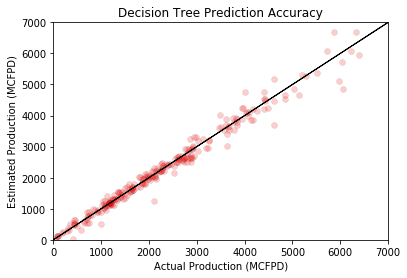

In [150]:
my_first_tree = tree.DecisionTreeRegressor()
my_first_tree = my_first_tree.fit(X_train, y_train)

plt.subplot(111)
check_model_tree(my_first_tree,X_test["Por"],X_test["Brittle"],y_test["Prod"],'Decision Tree Prediction Accuracy')

test_error = validation_error(X_test, y_test, my_first_tree)
train_error = training_error(X_train, y_train, my_first_tree)

print("Testing Error =",test_error)
print("Training Error =",train_error)

As we can see when we do not constrain the decision tree we got a training error of zero and a validation error in the 140,000s! This indicates that our decision tree overfit to our data. 

Let's verify by plotting the training data against our model.

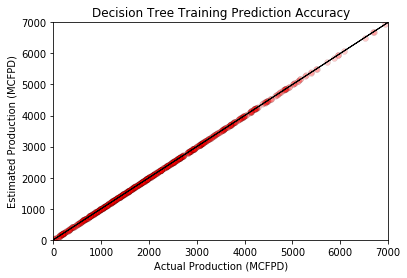

In [151]:
plt.subplot(111)
check_model_tree(my_first_tree,X_train["Por"],X_train["Brittle"],y_train["Prod"],'Decision Tree Training Prediction Accuracy')

As we can see above, the training data fits the model perfectly which indicates that our model is overfit.

Now let's try adding some constraints.

Testing Error = 280372.1885090101
Training Error = 78405.49193373055


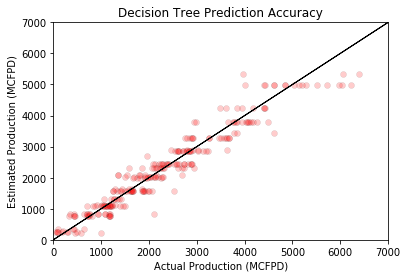

In [162]:
max_leaf_nodes = 30
max_depth = 10
min_sample_leaf = 5

my_second_tree = tree.DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, max_depth = max_depth, min_samples_leaf=min_sample_leaf)
my_second_tree = my_second_tree.fit(X_train, y_train)

check_model_tree(my_second_tree,X_test["Por"],X_test["Brittle"],y_test["Prod"],'Decision Tree Prediction Accuracy')

test_error = validation_error(X_test, y_test, my_second_tree)
train_error = training_error(X_train, y_train, my_second_tree)

print("Testing Error =",test_error)
print("Training Error =",train_error)

plt.show()

Here we see that the training error has increased thus reducing the overfitting we were seeing before. Let's plot the training data vs our model to compare like we did before.

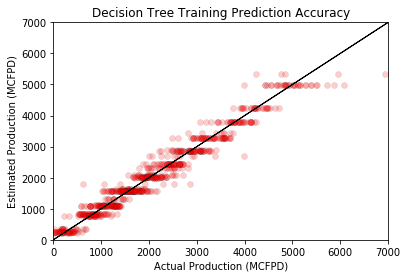

In [164]:
check_model_tree(my_second_tree,X_train["Por"],X_train["Brittle"],y_train["Prod"],'Decision Tree Training Prediction Accuracy')

We can see this is much better in terms of overfit. Now  let's tune our model to establish a benchmark.

#### Hyperparameter Tuning

Now let's vary the decision tree complexity and find the complexity that minimizes MSE in testing

* the code below loops over maximum leaf nodes, regions

* we set miniumum number of samples to 1 to ensure we get the desired number of leaf nodes

In [165]:
trees = []
error = []
var_exp = [] 
nodes = []

inodes = 2
while inodes < 375:
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=inodes)
    my_tree = my_tree.fit(X_train, y_train)
    trees.append(my_tree)

    predict_train = my_tree.predict(np.c_[X_test["Por"],X_test["Brittle"]])
    
    error.append(metrics.mean_squared_error(y_test["Prod"],predict_train))
    var_exp.append(metrics.explained_variance_score(y_test["Prod"],predict_train))    

    all_nodes = my_tree.tree_.node_count             
    decision_nodes = len([x for x in my_tree.tree_.feature if x != _tree.TREE_UNDEFINED]) 
    terminal_nodes = all_nodes - decision_nodes
    nodes.append(terminal_nodes)
    
    inodes+=1

Let's see how our set of tree models form simple to complicated performed with an  accuracy measured as mean square error for the training data.

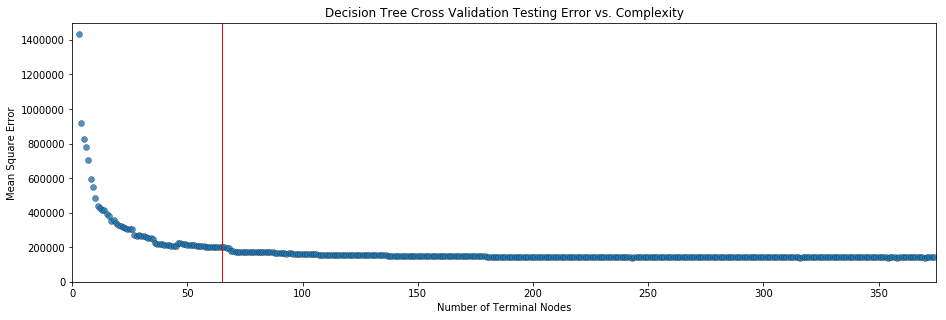

In [175]:
plt.figure(figsize=(8,6))
plt.scatter(nodes,error,s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.arrow(65,0,0,1500000,width=0.02,color='red',head_length=0.0,head_width=0.0)
plt.title('Decision Tree Cross Validation Testing Error vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
plt.xlim(0,375); plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.6, wspace=0.2, hspace=0.2)
plt.show()

It is useful to evaluate the performance of our tree by observing the accuracy vs. complexity trade-off.  Also, it was useful for us to observed the tree model over the feature space as we incrementally add terminal nodes. We can graphically observe the hierarical binary splitting quite clearly.  

For a more robust result, let's try k-fold cross validation. sklearn has a built in cross validation method called cross_val_score that we can use to:

1. Apply k-fold approach with iterative separation of training and testing data
2. Automate the model construction, looping over folds and averaging the metric of interest

Let's try it out on our trees with variable number of terminal nodes.  Note the cross validation is set to use 4 processors, but still will likely take a couple of minutes to run.

In [171]:
score = []                                                     # code from StackOverFlow by Dimosthenis
node = []
print('Complete of ' + str(300) + ': ', end =" ")
for inodes in range(2,300):
    my_tree = tree.DecisionTreeRegressor(max_leaf_nodes=inodes) 
    scores = cross_val_score(estimator=my_tree, X= np.c_[my_data_subset['Por'],my_data_subset['Brittle']],y=my_data_subset['Production'], cv=5, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score.append(abs(scores.mean()))
    node.append(inodes)
    print(str(inodes)+ ', ', end =" ")

Complete of 300:  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,  149,  150,  151,  152,  153,  154,  155,  156,  157,  158,  159,  160,  161,  162,  163,  164,  165,  166,  167,  168,  169,  170,  171,  172,  173,  174,  175,  176,  177,  178,  179,  180,  181,  182,  18

The output is an array of average scores (MSE) over the k-folds for each level of complexity (number of terminal nodes) and the maximum number of terminal nodes parameter in another array.

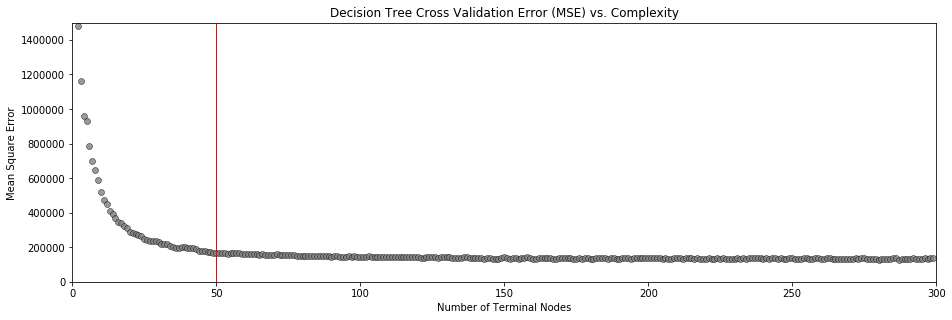

In [174]:
plt.figure(figsize=(8,6))
plt.arrow(50,0,0,1500000,width=0.02,color='red',head_length=0.0,head_width=0.0)
plt.scatter(node,score,s=None, c="grey", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, verts=None, edgecolors="black")
plt.title('Decision Tree Cross Validation Error (MSE) vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
plt.xlim(0,300); plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.6, wspace=0.2, hspace=0.2)
plt.show()

It is clear that at about 50 terminal nodes minimizes the test mean square error.

* all our train and test cross validation or k-fold cross validation was to get this one value, the model **hyperparameter**  

* now let's take that hyperparameter and train on all the data, this is our **final model**

Variance Explained = 0.98 Cor = 0.99
Testing Error = 52262.72595632266
Training Error = 45707.03161172697


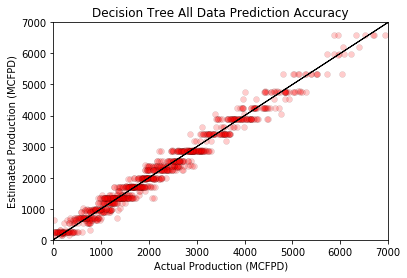

In [183]:
my_tuned_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=50)
my_tuned_tree = my_tuned_tree.fit(X_all, y_all)

check_model_tree(my_tuned_tree,X_all["Por"],X_all["Brittle"],y_all["Production"],'Decision Tree All Data Prediction Accuracy')

test_error = validation_error(X_test, y_test, my_tuned_tree)
train_error = training_error(X_train, y_train, my_tuned_tree)
mse_error = training_error(X_all, y_all, my_tuned_tree)

print("Testing Error =",test_error)
print("Training Error =",train_error)

plt.show()

Here we see that we now have a training error and testing error that are close in magnitude.

Our tuned model will be our benchmark for decision trees.

Here are the summarized statistics for this case:
* seed = 73093 
* max_leaf_nodes = 50
* min_samples_leaf = 1
* MSE = 52262.73 
* Variance Explained = 0.98
* Correlation = 0.99


Now we are going to test our model, like we did with random forest, to see how changing different parameter will cause it to overfit.

Let's start with a simple experiment in which we will only change the size of the training and testing samples to see how that affects our training and validation error. In theory, the greater the training size, the smaller the training error will be, thus the more overfit we will have.

#### Sample Size

Let's change our testing and training samples and record the training and validation errors.

In [190]:
#We will use the same hyperparameters as our benchmark case
seed = 73093     
max_leaf_nodes = 50
min_samples_leaf = 1
testing_size = .05

training_error_array = []
testing_error_array = []
testing_size_array = []

mse_array = []
var_explained_array = []
cor_array = [] 

while testing_size <= 1:
    
    my_data_subset = my_data.iloc[0:1000,[0,3,6]]                # extract just por, brittle and prod with 100 samples
    X_all = my_data_subset.iloc[:,[0,1]]; y_all = my_data_subset.iloc[:,[2]]   # training and testing together
    X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,[0,1]], my_data_subset.iloc[:,2], test_size=testing_size, random_state=73093)
    y_train = pd.DataFrame({'Prod':y_train.values})
    y_test = pd.DataFrame({'Prod':y_test.values})
    
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=50)
    my_tree = my_tree.fit(X_train, y_train)
    
    predict_train = my_tree.predict(np.c_[X_test["Por"],X_test["Brittle"]])
    
    #check_model_tree(my_tree,X_test["Por"],X_test["Brittle"],y_test["Prod"],'Decision Tree All Data Prediction Accuracy')

    test = validation_error(X_test, y_test, my_tree)
    train = training_error(X_train, y_train, my_tree)
   
    mean = metrics.mean_squared_error(y_test,predict_train)
    var = metrics.explained_variance_score(y_test,predict_train)
    corr = math.sqrt(metrics.r2_score(y_test,predict_train))
    
    
    testing_size_array.append(testing_size)
    training_error_array.append(train)
    testing_error_array.append(test)
    mse_array.append(mean)
    var_explained_array.append(var)
    cor_array.append(corr)
    
    testing_size += .05

Text(0,0.5,'Error')

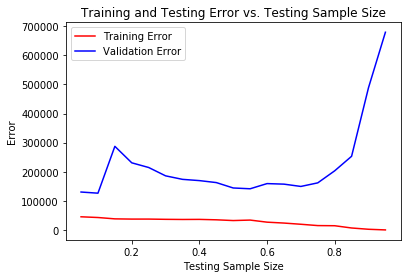

In [191]:
plt.plot(testing_size_array, training_error_array, c='red', label = 'Training Error')
plt.plot(testing_size_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Testing Sample Size') 
plt.xlabel('Testing Sample Size')
plt.ylabel('Error')

Recall, overfit occurs when we have a small training error and a large testing error. Based on the above graph we see evidence of overfit when the testing size is at a little more than .70. Both of our errors are decreasing until this point where the validation error suddenly increases while the training error continues to decrease. Ideally you want your testing and training to be as close to each other and as small as possible so the best testing size would somewhere around .55

Let's see how MSE, Variance Explained, and Correlation compare as we vary training sample size.

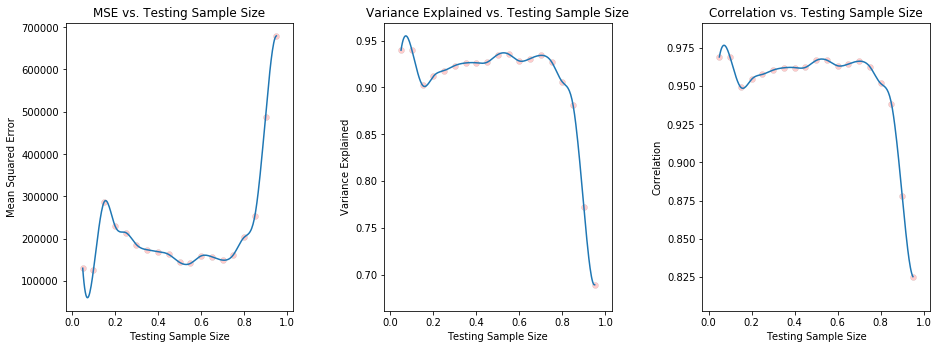

In [192]:
plt.subplot(131)
plt.scatter(testing_size_array,mse_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('MSE vs. Testing Sample Size') 
plt.xlabel('Testing Sample Size')
plt.ylabel('Mean Squared Error')
testing_size_array_new = np.linspace(min(testing_size_array), max(testing_size_array), 300)  
mse_smooth = spline(testing_size_array, mse_array, testing_size_array_new)
plt.plot(testing_size_array_new,mse_smooth)


plt.subplot(132)
plt.scatter(testing_size_array,var_explained_array, s=None, c='red', marker=None, cmap=None, norm=None, \
            vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black") 
plt.title('Variance Explained vs. Testing Sample Size') 
plt.xlabel('Testing Sample Size')
plt.ylabel('Variance Explained') 
var_smooth = spline(testing_size_array, var_explained_array, testing_size_array_new)
plt.plot(testing_size_array_new,var_smooth)


plt.subplot(133)
plt.scatter(testing_size_array,cor_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Correlation vs. Testing Sample Size') 
plt.xlabel('Testing Sample Size')
plt.ylabel('Correlation')
cor_smooth = spline(testing_size_array, cor_array, testing_size_array_new)
plt.plot(testing_size_array_new,cor_smooth)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

#### Max Leaf Nodes
Let's observe the training and validation errors, MSE, Var, and the Cor if we only change the max leaf nodes.

In [196]:
seed = 73093     
max_leaf_nodes = 2
min_samples_leaf = 1
testing_size = .55                           #per our determination above we will use .4

training_error_array = []
testing_error_array = []
leaf_array = []

mse_array = []
var_explained_array = []
cor_array = [] 

while max_leaf_nodes <= 50:
    
    my_data_subset = my_data.iloc[0:1000,[0,3,6]]                # extract just por, brittle and prod with 100 samples
    X_all = my_data_subset.iloc[:,[0,1]]; y_all = my_data_subset.iloc[:,[2]]   # training and testing together
    X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,[0,1]], my_data_subset.iloc[:,2], test_size=testing_size, random_state=73093)
    y_train = pd.DataFrame({'Prod':y_train.values})
    y_test = pd.DataFrame({'Prod':y_test.values})
    
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=max_leaf_nodes)
    my_tree = my_tree.fit(X_train, y_train)
    
    predict_train = my_tree.predict(np.c_[X_test["Por"],X_test["Brittle"]])
    
    #check_model_tree(my_tree,X_test["Por"],X_test["Brittle"],y_test["Prod"],'Decision Tree All Data Prediction Accuracy')

    test = validation_error(X_test, y_test, my_tree)
    train = training_error(X_train, y_train, my_tree)
   
    mean = metrics.mean_squared_error(y_test,predict_train)
    var = metrics.explained_variance_score(y_test,predict_train)
    corr = math.sqrt(metrics.r2_score(y_test,predict_train))
    
    
    leaf_array.append(max_leaf_nodes)
    training_error_array.append(train)
    testing_error_array.append(test)
    mse_array.append(mean)
    var_explained_array.append(var)
    cor_array.append(corr)
    
    max_leaf_nodes += 1

Text(0,0.5,'Error')

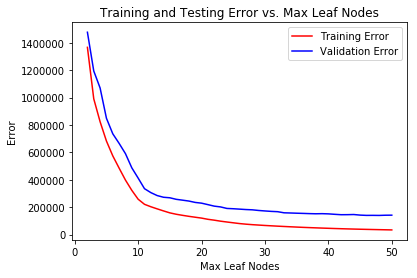

In [199]:
plt.plot(leaf_array, training_error_array, c='red', label = 'Training Error')
plt.plot(leaf_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Max Leaf Nodes') 
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Error')

As we can see from this graph, increasing the max leaf nodes decreases our training and validation errors until they eventually flatline. The flatline could be an indication of underfitting, but it is most likely showing how the model is not going to overfit with increasing leaf nodes.

Let's see how MSE, Variance Explained, and Correlation compare as we vary training sample size.

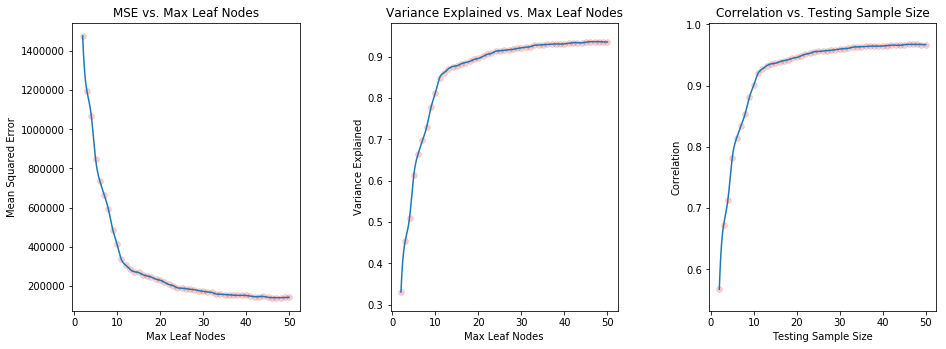

In [198]:
plt.subplot(131)
plt.scatter(leaf_array,mse_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('MSE vs. Max Leaf Nodes') 
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Mean Squared Error')
leaf_array_new = np.linspace(min(leaf_array), max(leaf_array), 300)  
mse_smooth = spline(leaf_array, mse_array, leaf_array_new)
plt.plot(leaf_array_new,mse_smooth)


plt.subplot(132)
plt.scatter(leaf_array,var_explained_array, s=None, c='red', marker=None, cmap=None, norm=None, \
            vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black") 
plt.title('Variance Explained vs. Max Leaf Nodes') 
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Variance Explained') 
var_smooth = spline(leaf_array, var_explained_array, leaf_array_new)
plt.plot(leaf_array_new,var_smooth)


plt.subplot(133)
plt.scatter(leaf_array,cor_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Correlation vs. Max Leaf Nodes') 
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Correlation')
cor_smooth = spline(leaf_array, cor_array, leaf_array_new)
plt.plot(leaf_array_new,cor_smooth)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

#### Min Samples Leaf
Let's observe the training and validation errors, MSE, Var, and the Cor if we only change the min samples leaf.

In [200]:
seed = 73093     
max_leaf_nodes = 30
min_samples_leaf = 1
testing_size = .55                           

training_error_array = []
testing_error_array = []
leaf_array = []

mse_array = []
var_explained_array = []
cor_array = [] 

while min_samples_leaf <= 50:
    
    my_data_subset = my_data.iloc[0:1000,[0,3,6]]                # extract just por, brittle and prod with 100 samples
    X_all = my_data_subset.iloc[:,[0,1]]; y_all = my_data_subset.iloc[:,[2]]   # training and testing together
    X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,[0,1]], my_data_subset.iloc[:,2], test_size=testing_size, random_state=73093)
    y_train = pd.DataFrame({'Prod':y_train.values})
    y_test = pd.DataFrame({'Prod':y_test.values})
    
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_leaf_nodes=max_leaf_nodes)
    my_tree = my_tree.fit(X_train, y_train)
    
    predict_train = my_tree.predict(np.c_[X_test["Por"],X_test["Brittle"]])
    
    #check_model_tree(my_tree,X_test["Por"],X_test["Brittle"],y_test["Prod"],'Decision Tree All Data Prediction Accuracy')

    test = validation_error(X_test, y_test, my_tree)
    train = training_error(X_train, y_train, my_tree)
   
    mean = metrics.mean_squared_error(y_test,predict_train)
    var = metrics.explained_variance_score(y_test,predict_train)
    corr = math.sqrt(metrics.r2_score(y_test,predict_train))
    
    
    leaf_array.append(min_samples_leaf)
    training_error_array.append(train)
    testing_error_array.append(test)
    mse_array.append(mean)
    var_explained_array.append(var)
    cor_array.append(corr)
    
    min_samples_leaf += 1

Text(0,0.5,'Error')

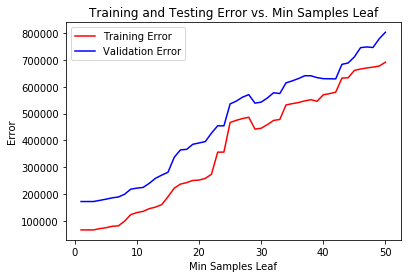

In [201]:
plt.plot(leaf_array, training_error_array, c='red', label = 'Training Error')
plt.plot(leaf_array, testing_error_array, c = 'blue', label = 'Validation Error')
plt.legend()
plt.title('Training and Testing Error vs. Min Samples Leaf') 
plt.xlabel('Min Samples Leaf')
plt.ylabel('Error')

We can see here that as we increase the min samples leaf both the validation and training error increase. This however does not lead to overfit, it actually leads to the opposite.

Let's observe the MSE, Var, and the Cor.

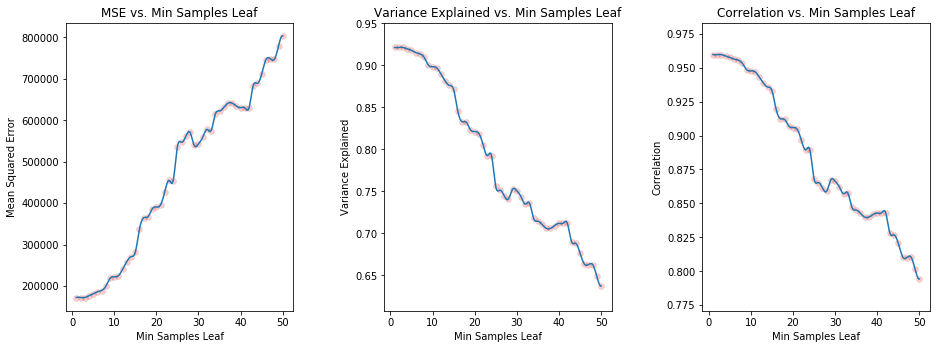

In [203]:
plt.subplot(131)
plt.scatter(leaf_array,mse_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('MSE vs. Min Samples Leaf') 
plt.xlabel('Min Samples Leaf')
plt.ylabel('Mean Squared Error')
leaf_array_new = np.linspace(min(leaf_array), max(leaf_array), 300)  
mse_smooth = spline(leaf_array, mse_array, leaf_array_new)
plt.plot(leaf_array_new,mse_smooth)


plt.subplot(132)
plt.scatter(leaf_array,var_explained_array, s=None, c='red', marker=None, cmap=None, norm=None, \
            vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black") 
plt.title('Variance Explained vs. Min Samples Leaf') 
plt.xlabel('Min Samples Leaf')
plt.ylabel('Variance Explained') 
var_smooth = spline(leaf_array, var_explained_array, leaf_array_new)
plt.plot(leaf_array_new,var_smooth)


plt.subplot(133)
plt.scatter(leaf_array,cor_array, s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, \
            vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Correlation vs. Min Samples Leaf') 
plt.xlabel('Min Samples Leaf')
plt.ylabel('Correlation')
cor_smooth = spline(leaf_array, cor_array, leaf_array_new)
plt.plot(leaf_array_new,cor_smooth)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

### Concluding Thoughts

As we observed from our experiments, it was much easier to get our decision tree to overfit. In fact, just running it unconstrained on our data led to overfit occurring.

It was much harder to try and get the random forest to overfit and in the end even after changing and testing many different parameters to adjust the model complexity we were unsuccessful in overfitting our random forest model. This proved its robust nature.

There are so many more exercises and tests that one could attempt to gain experience with breaking random forest models into overfitting, but for the purposes of this project, I'll end here. 